In [1]:
# if you use jupyter-lab, switch to %matplotlib inline instead
# %matplotlib inline
%matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

In [2]:
# use fixed random number generator seed to have reproducible results
random_seed = 123
rng = np.random.default_rng(random_seed)

In [3]:
# read in dataset1
d1_df = pd.read_csv('./datasets/dataset1.csv', header=None)
dataset1 = np.array(d1_df)
# it should contain 500 observations and each with 4 dimensional input
n_dataset1, d_dataset1 = dataset1.shape

In [4]:
n_dataset1, d_dataset1

(500, 4)

In [5]:
# read in dataset2
d2_df = pd.read_csv('./datasets/dataset2.csv', header=None)
dataset2, dataset2_labels = d2_df.iloc[:, 0:-1], d2_df.iloc[:, -1]
dataset2 = np.array(dataset2)
dataset2_labels = np.array(dataset2_labels).astype(int)
n_dataset2, d_dataset2 = dataset2.shape

In [6]:
n_dataset2, d_dataset2

(500, 3000)

In [7]:
# evaluate clustering performance by normalised mutual information.
# use Kmeans to learn the clusters: use the first four rows as centroids
km_dataset2 = KMeans(n_clusters=4, init=dataset2[0:4,:]).fit(dataset2)
# should expect approximately < 0.35 performance by using Kmeans
normalized_mutual_info_score(km_dataset2.labels_, dataset2_labels)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.30872980833029307

### Spherical K-means
The first task is to implement a variant of K-means algorithm, which is called *Spherical K-means*. The algorithm follows a similar procedure as K-means but with slightly different assignment and update steps. In the following, we will explain the spherical K-means algorithm. 


**Initialisation step**: Start with randomly selecting $K$ data points as the centroid of $K$ clusters. 

**Assignment step**: *Spherical K-means* assigns a data point to the closest centroid based on *cosine distance* rather than Euclidean distance; specifically, for $i=1,\ldots, n$

$$z^{(i)} \leftarrow \arg\min_{k} \left (1- \frac{\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_k\| \cdot \|\mathbf{x}^{(i)}\|}\right ),$$ where $\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} = \sum_{j=1}^d \boldsymbol{\mu}_{kj} \cdot \mathbf{x}^{(i)}_{j}$ denotes the inner product and $\|\mathbf{x}\|$ is $L_2$ norm of a vector $\mathbf{x}$: $\|\mathbf{x}\| = \sqrt{\mathbf{x}^\top \mathbf{x}}$.

**Update step**: *Spherical K-means* updates the centroids such that they are unit one vectors; for $k=1,\ldots, K$

$$\boldsymbol{\mu}_k \leftarrow \frac{\sum_{i=1}^n I(z^{(i)} =k) \cdot  \mathbf{x}^{(i)}}{\|\sum_{i=1}^n I(z^{(i)} =k) \cdot \mathbf{x}^{(i)}\|}.$$ Note that after the normalisation step, the centroids $\boldsymbol{\mu}_k$ are norm-one vectors: i.e. $\|\boldsymbol{\mu}_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps **until** the total cosine distance loss converges, where the loss is defined as
$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\boldsymbol{\mu}_{z^{(i)}}^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_{z^{(i)}}\| \cdot \|\mathbf{x}^{(i)}\|}\right ).$$



#### Task 1.1 Implementation of Spherical K-means

Your task is to complete the code for *assignment* and *update* steps at the given code template of `sphericalKmeans`.

The method `sphericalKmeans` has

**Inputs**:
* `data`: a $n\times d$ matrix to cluster, i.e. each row of $\texttt{data}$ is one observation $x_i$
* `K`: the number of the clusters
* `tol`: tolerence of error, which is used to check whether the loss has converged so the iteration can stop
* `maxIters`: the maximum number of iterations that is allowed

**Outputs**:
* `losses`: the whole trajectory of losses over the iterations
* `zs`: the clustering labels
* `us`: the learnt $K$ centroids

Feel free to write extra helper methods to make your implementation modularised. You may also rewrite the method altogether as long as your method respect the given mtehod's input/output signature. 

In [8]:
def sphericalKmeans(data, K=3, tol= 1e-4, maxIters= 100):
    n, d = data.shape 
    losses = []
    # initialisation: randomly assign K observations as centroids
    # feel free to use a different but sensible initialisation method    
    init_us_ids = rng.integers(n, size = K)
    us = data[init_us_ids, :]
    zs = np.zeros(n).astype(int)
    
    # loop until converge 
     
    for i in range(maxIters):
        
        #initialise variables
        loss=0
        distance=np.zeros(K).astype(float)#cosine distance
        us_=np.zeros([K,d]) #temporary variable for centroids
        
        for k in range(n):
            for j in range(K):
                distance[j]=1-np.dot(us[j,:],data[k,:])/(np.linalg.norm(us[j,:])*np.linalg.norm(data[k,:]))
            
            #assign each point to its centroid 
            zs[k]=np.where(distance == distance.min())[0]
            
            #sum of all points around centroid they belong
            us_[zs[k],:]+=data[k,:]

            loss+=1-np.dot(us[zs[k],:],data[k,:])/(np.linalg.norm(us[zs[k],:])*np.linalg.norm(data[k,:]))
            
        #normalise each centroid to make it a unit vector  
        for l in range(K):
            us_[l,:]=us_[l,:]/np.linalg.norm(us_[l,:])
            
        #update the new centroid from the temp variable
        us=us_    
        
        losses.append(loss)
        # convergence check 
        if i>=1:
            if abs(losses[i]-losses[i-1]) <=tol:
                break
               
    return losses, zs, us

#### Task 1.2 Evaluation

Run your implemented algorithm on `dataset1` with $K =3$. Note that like K-means, Spherical K-means also suffers from bad initialisations. To deal with that, we usually run the algorithm multiple times with different random initialisations. To make your life easier, you may want to write a wrapper method that does it automatically.

Please report the following information based on your results: 
* the learned 3 centroids
* and also plot the loss trajectory.

If you run multiple times, you only need to report the results for the best one.

In [9]:
#results remains the same when run multiple times but with different convergence speed, hence 1 result is presented below
losses1,zs1,us1=sphericalKmeans(dataset1, K=3, tol= 1e-4, maxIters= 100)




In [10]:
dataset1

array([[ 0.12659558,  0.85826973,  0.00395282,  0.49732385],
       [-0.01274353,  0.66811427,  0.04512084,  0.74257999],
       [-0.53988539,  0.47353247, -0.41082472,  0.56170616],
       ...,
       [-0.36179708,  0.76197173, -0.33878559,  0.41680485],
       [-0.22717591,  0.67859685,  0.21204301,  0.66553376],
       [-0.74409171, -0.00909995, -0.59718581, -0.29935568]])

<IPython.core.display.Javascript object>


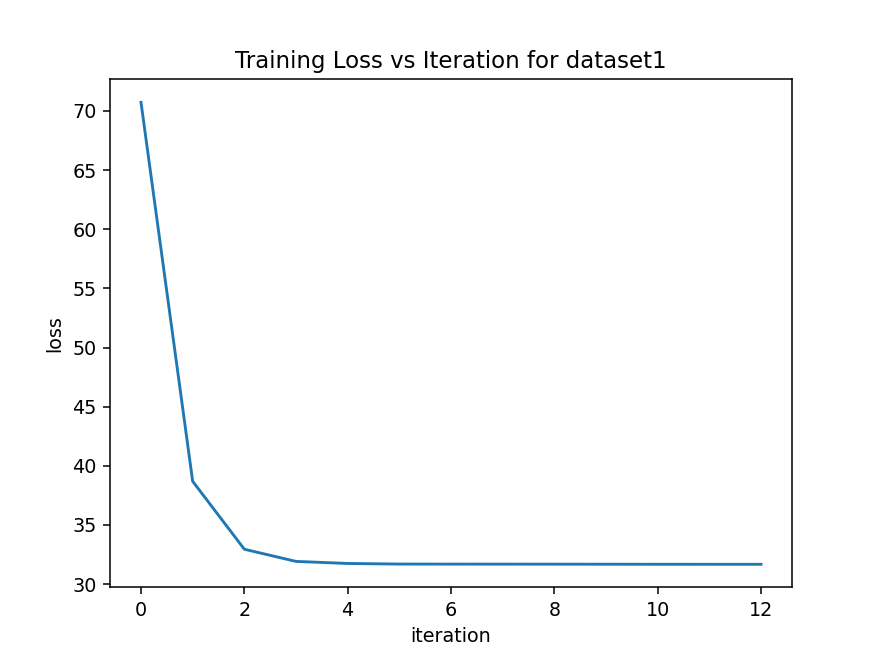

In [11]:
plt.figure()
plt.plot(losses1)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training Loss vs Iteration for dataset1")
plt.show()

In [12]:
print('Losses:','\n',losses1,'\n\n','Classification Labels:\n',zs1,'\n\n','Centroids:\n',us1)

Losses: 
 [70.73436048211865, 38.692105239706486, 32.94659094747628, 31.91722821719553, 31.742834707577828, 31.692572132412447, 31.688380304329733, 31.686596048035803, 31.683909927702167, 31.67862363908571, 31.67437705299367, 31.67273873380425, 31.67273873380425] 

 Classification Labels:
 [0 0 2 0 1 1 2 2 2 1 1 2 0 2 1 2 0 2 1 1 0 2 2 1 1 2 1 2 2 0 2 1 0 2 0 2 2
 2 2 2 2 1 1 2 2 1 0 2 1 2 1 0 2 1 1 1 2 0 2 0 1 1 1 2 2 1 1 2 2 0 0 1 2 1
 0 1 1 2 1 0 1 1 1 0 0 2 0 2 0 2 1 0 0 1 1 2 0 1 0 2 2 2 1 0 2 2 1 0 0 2 0
 1 2 2 1 2 2 1 0 2 0 0 1 2 2 2 1 0 2 1 2 2 1 2 0 0 2 0 1 0 1 0 1 0 0 2 1 0
 2 2 2 0 0 1 0 1 0 2 1 2 1 1 2 1 2 0 1 2 1 2 2 1 1 1 0 0 0 1 1 0 1 0 2 0 1
 2 0 2 1 0 0 0 1 2 0 1 2 2 0 2 2 2 2 0 2 0 0 1 0 0 2 1 1 1 2 2 1 2 2 0 0 1
 0 1 0 2 0 1 2 0 1 2 2 1 0 1 2 2 2 2 1 1 0 1 2 0 2 1 1 0 0 2 0 2 1 2 2 0 1
 2 2 1 1 1 0 2 0 0 0 0 1 0 0 1 2 1 2 1 1 1 2 0 2 1 0 0 1 1 2 2 1 1 2 0 1 0
 2 2 2 0 2 1 0 2 0 1 2 0 1 2 0 2 2 1 2 2 1 0 2 2 0 0 0 0 0 0 0 2 1 1 2 1 0
 1 0 1 0 2 2 1 0 1 0 2 2 0 0 0 0 1

Now run your implemented algorithm on `dataset2` with $K =4$. And report the normalised mutual information between the returned cluster labels and true labels.

In [13]:
# run spherical K-means on dataset2 and report your NMI results here
#run multiple times to find result with best normalized_mutual_info_score
max_=0
for i in range(10):
    losses2,zs2,us2=sphericalKmeans(dataset2, K=4, tol= 1e-4, maxIters= 100)
    if i==0:
        max_=normalized_mutual_info_score(dataset2_labels,zs2)
        best_losses2,best_zs2,best_us2=losses2,zs2,us2
    else:
        if normalized_mutual_info_score(dataset2_labels,zs2)>=max_:
            max_=normalized_mutual_info_score(dataset2_labels,zs2)
            best_losses2,best_zs2,best_us2=losses2,zs2,us2

<IPython.core.display.Javascript object>


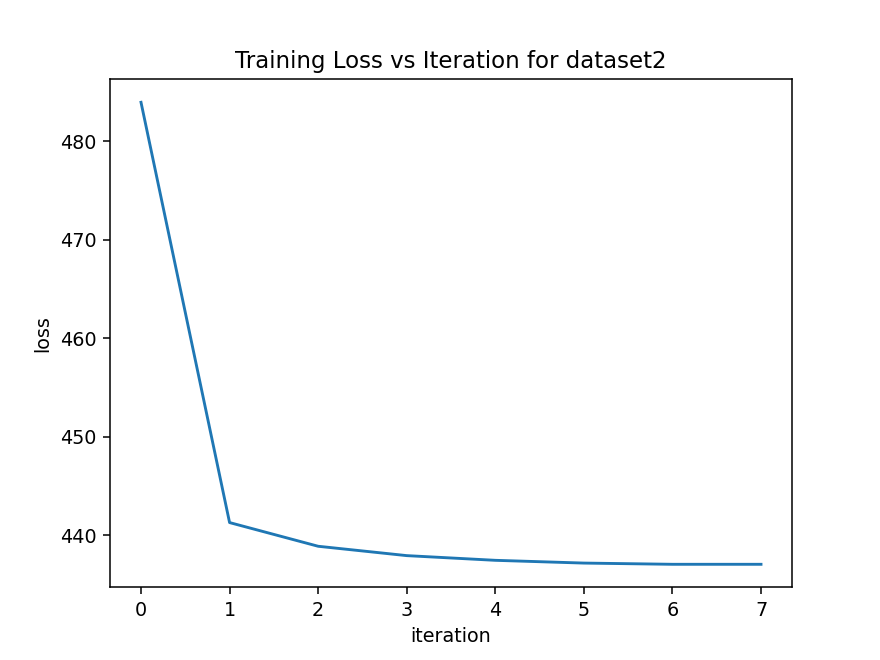

In [14]:
plt.figure()
plt.plot(best_losses2)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training Loss vs Iteration for dataset2")
plt.show()

In [15]:
print('Losses:','\n',best_losses2,'\n\n','Classification Labels:\n',best_zs2,'\n\n','Centroids:\n',best_us2)

Losses: 
 [483.93065485281886, 441.3066356911614, 438.9034758123162, 437.9540678436344, 437.47802667526014, 437.1979239623367, 437.07408511006116, 437.07408511006116] 

 Classification Labels:
 [3 2 1 0 2 2 0 3 0 0 3 3 0 1 0 3 0 3 2 0 3 3 2 0 3 2 3 0 3 2 2 3 0 0 3 3 1
 2 1 2 1 1 0 1 1 1 0 2 3 3 1 3 3 0 2 3 3 1 2 3 0 3 3 1 1 1 3 1 3 3 3 2 0 3
 2 3 3 2 0 1 2 0 3 3 0 3 3 2 0 3 2 2 0 0 0 1 0 0 2 3 3 3 0 1 1 1 0 2 0 3 3
 3 0 2 1 0 0 2 3 0 1 3 1 3 1 3 2 1 2 0 2 3 1 2 3 3 1 3 2 3 3 0 3 1 1 3 3 0
 0 3 2 0 1 3 0 3 2 0 3 2 2 3 3 3 2 0 1 0 3 1 3 3 2 3 0 3 2 0 1 1 2 2 1 0 3
 1 2 2 3 0 2 0 3 3 0 2 1 3 0 3 0 2 3 2 0 3 3 2 3 0 0 3 0 1 3 2 0 1 1 0 2 0
 3 1 3 1 2 0 2 1 1 2 2 2 0 0 3 2 3 0 2 0 0 3 2 1 0 1 3 3 3 3 1 0 2 0 0 3 0
 1 1 3 3 1 2 2 2 2 0 1 1 3 2 2 1 1 3 1 3 1 2 3 2 1 3 0 0 3 0 0 3 0 2 2 3 1
 0 0 3 3 3 0 2 3 0 0 1 1 0 2 3 2 1 1 3 2 1 2 0 1 3 2 0 0 3 0 0 0 1 3 0 3 0
 0 0 0 1 2 0 1 2 2 3 3 0 0 3 0 1 3 3 3 0 0 0 3 2 1 3 0 0 3 0 0 1 2 0 2 1 2
 3 0 0 2 0 1 3 1 0 3 1 0 3 2 1 1 3 0 0 0 0 3 0 0 3 1 3 1

In [16]:
dataset2.shape


(500, 3000)

In [17]:
dataset1.shape

(500, 4)

#### In contrast with the training of dataset1, losses for dataset2 decrease much less in comparison with dataset1 during training which shows the limitations when dealing with extremely high dimensional data, as with the 3000 features in dataset2 in comparison with the only 4 features of dataset1

In [18]:
dataset2_labels

array([4, 2, 3, 2, 2, 2, 1, 2, 1, 2, 4, 4, 1, 1, 2, 4, 2, 4, 3, 2, 3, 4,
       1, 2, 4, 1, 4, 1, 4, 2, 2, 4, 1, 1, 3, 4, 2, 2, 1, 3, 1, 3, 1, 2,
       3, 2, 1, 1, 4, 4, 2, 3, 4, 1, 2, 4, 4, 1, 2, 2, 1, 4, 4, 1, 2, 3,
       4, 1, 3, 4, 4, 2, 1, 4, 3, 4, 4, 3, 3, 3, 2, 2, 4, 4, 1, 4, 4, 3,
       3, 4, 2, 1, 1, 3, 1, 3, 1, 2, 1, 4, 4, 4, 3, 2, 2, 2, 2, 3, 1, 4,
       4, 4, 1, 2, 2, 3, 1, 2, 4, 1, 3, 3, 1, 4, 3, 2, 3, 4, 1, 1, 1, 2,
       2, 4, 2, 4, 1, 4, 3, 4, 4, 1, 4, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 2,
       1, 4, 2, 1, 4, 3, 2, 2, 4, 4, 1, 2, 3, 2, 4, 3, 3, 4, 2, 4, 1, 4,
       3, 1, 1, 3, 3, 2, 2, 1, 4, 3, 1, 3, 4, 1, 2, 2, 2, 3, 1, 1, 3, 4,
       1, 4, 1, 2, 3, 3, 2, 4, 2, 1, 4, 1, 1, 4, 1, 3, 4, 3, 2, 2, 2, 2,
       3, 3, 4, 3, 4, 3, 2, 2, 2, 1, 3, 1, 2, 4, 2, 3, 4, 1, 4, 1, 3, 1,
       1, 3, 4, 2, 3, 3, 3, 2, 4, 2, 3, 1, 2, 1, 1, 4, 3, 2, 3, 4, 4, 3,
       1, 3, 2, 2, 1, 3, 3, 4, 4, 2, 2, 3, 3, 3, 4, 2, 3, 4, 3, 2, 3, 1,
       1, 4, 1, 2, 4, 1, 1, 3, 4, 3, 1, 1, 4, 4, 4,

In [19]:
print('Normalized mutual info score:',normalized_mutual_info_score(dataset2_labels,best_zs2))

Normalized mutual info score: 0.3172502773485687


## Task 2. Bayesian Machine Learning


In this task, we are going to implement a simple MCMC algorithm to do Bayesian logistic regression. You will be guided to finish the task step by step. First, we read-in the dataset required for the task.

### Dataset
We are going to use the following simple dataset for this task. The dataset is read-in below and stored in variables `XX` and `yy`. There are in total 16 training instances.


In [20]:
d3_df = pd.read_csv('./datasets/dataset3.csv', header=0)
dataset3 = np.array(d3_df)
XX, yy = dataset3[:, 0:2], dataset3[:, -1]
XX = np.column_stack((np.ones(XX.shape[0]), XX))

### Task 2.1

The log-likelihood for the probabilistic logistic regression is defined as 

$$p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) = (\sigma^{(i)})^{y^{(i)}}(1-\sigma^{(i)})^{1-y^{(i)}},$$

where $\sigma^{(i)}(\mathbf{x}, \mathbf{w}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}}$ is the logistic regression's output. For simplicity, we assume the feature $\mathbf{x}$ vector includes dummy one and the weight parameter includes the bias.

Give the expression for the joint log-likelihood $\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X})$ for the probabilistic model, where $\mathbf{X}$ is the design matrix ($\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(1)}& \mathbf{x}^{(2)} & \ldots & \mathbf{x}^{(n)}\end{bmatrix}^\top$). 

#### Answer:

$$p(\textbf{D}|\mathbf{w}, \mathbf{x}^{(i)})= \prod_{i=1}^{n} p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)})$$
$$ln(p(\textbf{D}|\mathbf{w}, \mathbf{x}^{(i)}))=\sum_{i=1}^{n} ln( p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)})) $$
$$ln(p(\textbf{D}|\mathbf{w}, \mathbf{x}^{(i)}))=\sum_{i=1}^{n} y^{(i)}ln(\sigma^{(i)})+(1-y)ln(1-\sigma^{(i)})$$


#### Implement the joint likelihood method below:

In [21]:
def sigmoid(z):
    sig=1/(1+np.exp(-z))
    return sig

In [22]:
def log_likelihood(w, X=XX, y=yy):
    
    y_=X@w
    sig=sigmoid(y_)
    likehood=np.sum(y*np.log(sig)+ (1-y)*np.log(1-sig))
    return likehood

### Task 2.2

A Bayesian logistic regression model usually assumes a zero mean Gaussian prior for the weight parameter $\mathbf{w}$:

$$p(\mathbf{w}|\lambda) = \mathcal{N}_m\left(\mathbf{w}; \mathbf{0}, \frac{1}{\lambda}\mathbf{I}\right)=\prod_{d=1}^m \mathcal{N}(w_d; 0, 1/\lambda)$$

* where $\mathcal{N}_m$ denotes a $m-$dimensional Gaussian distribution and where $\lambda$ is the precision parameter of the Gaussian.

#### Write down an expression for the log-transformed prior $\ln p(\mathbf{w}|\lambda)$

#### Answer:

$$p(\mathbf{w}|\lambda)=\frac{1}{(\sqrt{2\pi/\lambda})^m}exp \Bigl\{-\frac{\lambda}{2} \sum_{j=1}^{m} w_j^2\Bigr\}$$
$$\ln p(\mathbf{w}|\lambda)=-\frac{\lambda}{2}\sum_{j=1}^{m} w_j^2 +C$$

### Task 2.3

Based on Bayes' rule, the unnormalised log posterior distribution is defined as

$$\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) = \ln p(\mathbf{w}|\lambda) + \ln p(\{y^{(i)}\}|\mathbf{X}, \mathbf{w}) +\text{const}$$

#### Write down an expression for the unnormalised log-transformed posterior:

#### Answer:

Substituting the expressions found in tasks 2.1 and 2.2 and removing the constant terms since they will cancel out when computing ratio $\mathbf{\alpha}$, gives the following expression:
$$\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) = -\frac{\lambda}{2}\sum_{j=1}^{m} w_j^2+ \sum_{i=1}^{n} y^{(i)}ln(\sigma^{(i)})+(1-y)ln(1-\sigma^{(i)})$$

#### Implement the unnormalised log posterior below:

In [23]:
def log_posterior(w, X=XX, y=yy, lambda0=1e-2):
    answer=log_likelihood(w, X, y)-lambda0/2*np.sum(w**2)
    
    return answer

#### Report the unnormalised log posterior value at $\mathbf{w} =\mathbf{0}$ and $\lambda = \frac{1}{100}$

In [24]:
log_posterior(np.zeros(XX.shape[1]), XX, yy, lambda0=1e-2)

-11.090354888959125

### Task 2.4

Implement a **Metropolis sampling** algorithm to draw samples from the unnormalised posterior:

$$\mathbf{w}^{(m)} \sim p(\mathbf{w}|\{y^{(i)}\},\mathbf{X}),\;\; \text{for }m = 1, \ldots, M$$

You should use the following proposal distribution

$$q(\mathbf{w}'|\mathbf{w}) = \mathcal{N}\left (\mathbf{w}, \left(\lambda \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X\right)^{-1}\right),$$

You should convince yourself that the proposal distribution is symmetric. To draw random samples from multivariate Gaussian distribution, you may use `rng.multivariate_normal(mean, cov, size=800)`, where `mean` and `cov` are the corresponding mean and covariance parameters.

In [25]:
def metropolis_bayes_logistic_reg(X=XX, y=yy, lambda0=1e-2, mc=5000, burnin=1000):
    lambda0=1e-2
    
    #covariance matrix
    cov=np.linalg.inv(lambda0+6/(np.pi)**2*np.transpose(X)@X)
    
    #initialise w
    w_current=np.zeros(XX.shape[1])
    #list that will store history of w
    w_samples=[w_current]
    
    for i in range(mc):
        #suggestion of new w
        w_new=rng.multivariate_normal(w_current, cov)
        
        #probability of acceptance of new w
        ratio=np.exp(log_posterior(w_new, XX, yy, lambda0=1e-2))/np.exp(log_posterior(w_current, XX, yy, lambda0=1e-2))
        a=min(ratio,1)
        accept=np.random.rand()<a
        
        #appending to list if accepted
        if accept:
            w_samples.append(w_new)
            w_current=w_new
    #removing the first 1000 samples
    w_samples=w_samples[burnin:] 
    
    
    
    return w_samples

##### Implement a Monte Carlo prediction method and use the method to replicate the following decision boundary plot. Note that the Monte Carlo prediction is defined as:

$$p(y_{test}|\mathbf{x}_{test}) \approx \frac{1}{M} \sum_{m=1}^M \sigma(\mathbf{x}_{test}, \mathbf{w}^{(m)})$$

You only need roughly $M=1000$ Monte Carlo samples to make accurate predictions.

##### Explain why the Bayesian prediction should be preferred in comparison with the frequentist's MAP/ML estimation.

#### MAP prediction is a regularised version of ML estimation, Bayesian prediction is still much better though since it's not a simple plug-in solution, by taking thousands of weight samples in a probabilistic way the best distribution of weights can be obtained which results in a much greater general performance besides the narrow region that the points belong.

In [26]:
def prediction_mc(xtest, wsamples):
    prediction=np.mean(sigmoid(xtest@np.transpose(w_samples)))
    return prediction

In [27]:
w_samples=metropolis_bayes_logistic_reg()

In [ ]:
w_samples

In [29]:

x1=np.ones(100)

x2=np.linspace(0,10,100)
x3=np.linspace(0,10,100)
X, Y = np.meshgrid(x2, x3) 

Z=np.zeros([100,100])

In [30]:
for i in range(100):
    for j in range(100):
        Z[i,j]=prediction_mc(np.asarray([[1,X[i,j],Y[i,j]]]),w_samples)

<IPython.core.display.Javascript object>


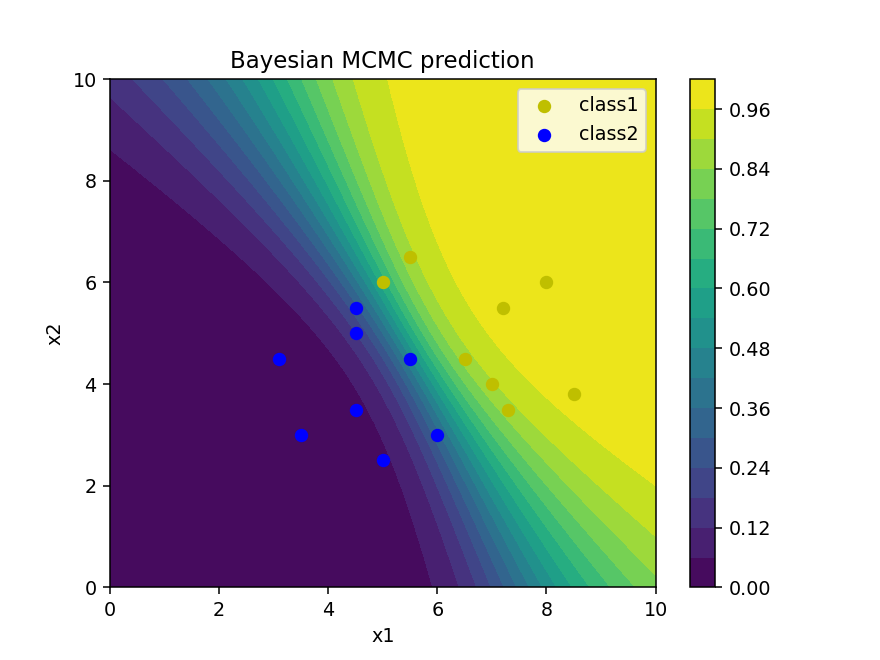

In [31]:
labels=['class1','class2']
plt.figure()
plt.contourf(X,Y,Z,levels=16)
plt.colorbar( orientation="vertical")
plt.scatter(XX[0:8,1],XX[0:8,2],color='y',label='class1')
plt.scatter(XX[8:16,1],XX[8:16,2],color='b',label='class2')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Bayesian MCMC prediction")
plt.legend()
plt.show()
